# Image features exercise
*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

We have seen that we can achieve reasonable performance on an image classification task by training a linear classifier on the pixels of the input image. In this exercise we will show that we can improve our classification performance by training linear classifiers not on raw pixels but on features that are computed from the raw pixels.

All of your work for this exercise will be done in this notebook.

In [1]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Load data
Similar to previous exercises, we will load CIFAR-10 data from disk.

In [2]:
from cs231n.features import color_histogram_hsv, hog_feature

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()

## Extract Features
For each image we will compute a **Histogram of Oriented
Gradients (HOG)** as well as a color histogram using the hue channel in HSV
color space. We form our final feature vector for each image by concatenating
the HOG and color histogram feature vectors.

Roughly speaking, **HOG should capture the texture of the image while ignoring
color information**, and **the color histogram represents the color of the input
image while ignoring texture.** As a result, we expect that using both together
ought to work better than using either alone. Verifying this assumption would
be a good thing to try for the bonus section.

The `hog_feature` and `color_histogram_hsv` functions both operate on a single
image and return a feature vector for that image. The extract_features
function takes a set of images and a list of feature functions and evaluates
each feature function on each image, storing the results in a matrix where
each column is the concatenation of all feature vectors for a single image.

In [3]:
from cs231n.features import *

num_color_bins = 10 # Number of bins in the color histogram
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

Done extracting features for 1000 / 49000 images
Done extracting features for 2000 / 49000 images
Done extracting features for 3000 / 49000 images
Done extracting features for 4000 / 49000 images
Done extracting features for 5000 / 49000 images
Done extracting features for 6000 / 49000 images
Done extracting features for 7000 / 49000 images
Done extracting features for 8000 / 49000 images
Done extracting features for 9000 / 49000 images
Done extracting features for 10000 / 49000 images
Done extracting features for 11000 / 49000 images
Done extracting features for 12000 / 49000 images
Done extracting features for 13000 / 49000 images
Done extracting features for 14000 / 49000 images
Done extracting features for 15000 / 49000 images
Done extracting features for 16000 / 49000 images
Done extracting features for 17000 / 49000 images
Done extracting features for 18000 / 49000 images
Done extracting features for 19000 / 49000 images
Done extracting features for 20000 / 49000 images
Done extr

## Train SVM on features
Using the multiclass SVM code developed earlier in the assignment, train SVMs on top of the features extracted above; this should achieve better results than training SVMs directly on top of raw pixels.

In [4]:
# Use the validation set to tune the learning rate and regularization strength

from cs231n.classifiers.linear_classifier import LinearSVM

# learning_rates = [1e-6, 5e-6, 1e-4, 5e-4]
# regularization_strengths = [1e3, 2e3, 5e3, 1e4, 2e4, 5e4]

learning_rates = [10**(-f) for f in np.arange(2,4,0.2)]
regularization_strengths = [10**(f) for f in np.arange(.5,1.5,.2)]

results = {}
best_val = -1
best_svm = None

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained classifer in best_svm. You might also want to play          #
# with different numbers of bins in the color histogram. If you are careful    #
# you should be able to get accuracy of near 0.44 on the validation set.       #
################################################################################
def accuracy(y_pred, y_true):
    return np.mean(y_pred == y_true)

for rate in learning_rates:
    for strength in regularization_strengths:
        svm = LinearSVM()
        svm.train(X_train_feats, y_train, learning_rate=rate, reg=strength, 
                  num_iters=1500, verbose=True)
        train_accuracy = accuracy(svm.predict(X_train_feats), y_train)
        validation_accuracy = accuracy(svm.predict(X_val_feats), y_val)
        
        results[(rate, strength)] = (train_accuracy, validation_accuracy)
        if validation_accuracy > best_val:
            best_val = validation_accuracy
            best_svm = svm
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

iteration 0 / 1500: loss 8.995722
iteration 100 / 1500: loss 6.375726
iteration 200 / 1500: loss 6.275292
iteration 300 / 1500: loss 6.226593
iteration 400 / 1500: loss 6.063527
iteration 500 / 1500: loss 6.475788
iteration 600 / 1500: loss 6.062167
iteration 700 / 1500: loss 6.715139
iteration 800 / 1500: loss 6.410121
iteration 900 / 1500: loss 6.663089
iteration 1000 / 1500: loss 6.132708
iteration 1100 / 1500: loss 6.178088
iteration 1200 / 1500: loss 6.137617
iteration 1300 / 1500: loss 6.764157
iteration 1400 / 1500: loss 6.185742
iteration 0 / 1500: loss 9.021260
iteration 100 / 1500: loss 7.347705
iteration 200 / 1500: loss 6.896989
iteration 300 / 1500: loss 6.781855
iteration 400 / 1500: loss 7.365125
iteration 500 / 1500: loss 6.994970
iteration 600 / 1500: loss 6.606764
iteration 700 / 1500: loss 7.158080
iteration 800 / 1500: loss 7.708058
iteration 900 / 1500: loss 6.777365
iteration 1000 / 1500: loss 6.759212
iteration 1100 / 1500: loss 7.266874
iteration 1200 / 1500: lo

iteration 600 / 1500: loss 6.265652
iteration 700 / 1500: loss 6.101270
iteration 800 / 1500: loss 6.097985
iteration 900 / 1500: loss 5.873448
iteration 1000 / 1500: loss 6.338364
iteration 1100 / 1500: loss 6.611513
iteration 1200 / 1500: loss 6.466564
iteration 1300 / 1500: loss 6.376447
iteration 1400 / 1500: loss 6.059895
iteration 0 / 1500: loss 9.008902
iteration 100 / 1500: loss 6.622226
iteration 200 / 1500: loss 7.092612
iteration 300 / 1500: loss 6.592170
iteration 400 / 1500: loss 6.961661
iteration 500 / 1500: loss 7.034013
iteration 600 / 1500: loss 6.842778
iteration 700 / 1500: loss 6.825221
iteration 800 / 1500: loss 7.134721
iteration 900 / 1500: loss 6.879145
iteration 1000 / 1500: loss 6.979615
iteration 1100 / 1500: loss 6.845913
iteration 1200 / 1500: loss 6.746368
iteration 1300 / 1500: loss 6.616376
iteration 1400 / 1500: loss 6.717309
iteration 0 / 1500: loss 9.008309
iteration 100 / 1500: loss 7.859167
iteration 200 / 1500: loss 7.445692
iteration 300 / 1500: 

iteration 1200 / 1500: loss 6.555855
iteration 1300 / 1500: loss 6.135817
iteration 1400 / 1500: loss 6.362264
iteration 0 / 1500: loss 9.016182
iteration 100 / 1500: loss 6.511817
iteration 200 / 1500: loss 6.388470
iteration 300 / 1500: loss 6.423621
iteration 400 / 1500: loss 6.652340
iteration 500 / 1500: loss 6.781585
iteration 600 / 1500: loss 6.606806
iteration 700 / 1500: loss 6.822691
iteration 800 / 1500: loss 6.738670
iteration 900 / 1500: loss 6.702803
iteration 1000 / 1500: loss 6.718026
iteration 1100 / 1500: loss 6.989349
iteration 1200 / 1500: loss 7.336882
iteration 1300 / 1500: loss 7.075329
iteration 1400 / 1500: loss 6.941986
iteration 0 / 1500: loss 9.018819
iteration 100 / 1500: loss 7.126976
iteration 200 / 1500: loss 7.549787
iteration 300 / 1500: loss 7.814259
iteration 400 / 1500: loss 7.225779
iteration 500 / 1500: loss 7.269015
iteration 600 / 1500: loss 7.556890
iteration 700 / 1500: loss 7.514946
iteration 800 / 1500: loss 7.669321
iteration 900 / 1500: lo

iteration 200 / 1500: loss 7.319673
iteration 300 / 1500: loss 7.008708
iteration 400 / 1500: loss 6.564773
iteration 500 / 1500: loss 6.363374
iteration 600 / 1500: loss 6.520601
iteration 700 / 1500: loss 6.800454
iteration 800 / 1500: loss 6.535039
iteration 900 / 1500: loss 6.204085
iteration 1000 / 1500: loss 6.843653
iteration 1100 / 1500: loss 6.793283
iteration 1200 / 1500: loss 6.411857
iteration 1300 / 1500: loss 6.838594
iteration 1400 / 1500: loss 6.685976
iteration 0 / 1500: loss 9.004753
iteration 100 / 1500: loss 7.960314
iteration 200 / 1500: loss 7.741044
iteration 300 / 1500: loss 7.073614
iteration 400 / 1500: loss 7.120202
iteration 500 / 1500: loss 7.446367
iteration 600 / 1500: loss 7.352042
iteration 700 / 1500: loss 7.518777
iteration 800 / 1500: loss 7.412605
iteration 900 / 1500: loss 7.173892
iteration 1000 / 1500: loss 7.446740
iteration 1100 / 1500: loss 7.048540
iteration 1200 / 1500: loss 7.360137
iteration 1300 / 1500: loss 7.379420
iteration 1400 / 1500

In [5]:
# Evaluate your trained SVM on the test set
y_test_pred = best_svm.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print(test_accuracy)

0.464


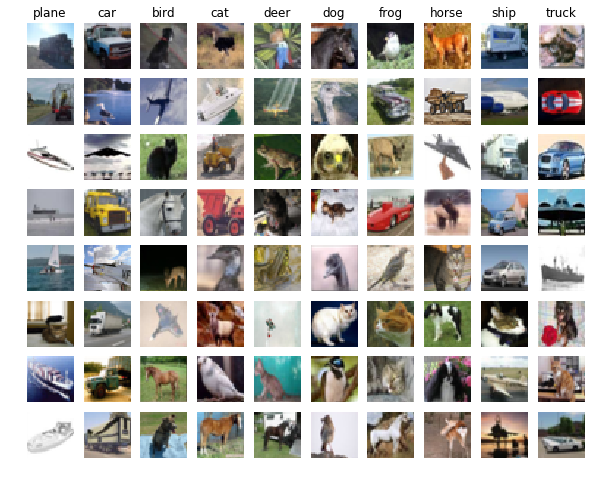

In [6]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".

examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

### Inline question 1:
Describe the misclassification results that you see. Do they make sense?

## Neural Network on image features
Earlier in this assigment we saw that training a two-layer neural network on raw pixels achieved better classification performance than linear classifiers on raw pixels. In this notebook we have seen that linear classifiers on image features outperform linear classifiers on raw pixels. 

For completeness, we should also try training a neural network on image features. This approach should outperform all previous approaches: you should easily be able to achieve over 55% classification accuracy on the test set; our best model achieves about 60% classification accuracy.

In [7]:
print(X_train_feats.shape)

(49000, 155)


In [28]:
from cs231n.classifiers.neural_net import TwoLayerNet
import time

input_dim = X_train_feats.shape[1]
num_classes = 10

best_val = -1
best_net = None

start = time.time()
################################################################################
# TODO: Train a two-layer neural network on image features. You may want to    #
# cross-validate various parameters as in previous sections. Store your best   #
# model in the best_net variable.                                              #
################################################################################
learning_rates = [1]
hidden_layer_size = [500]
num_iters = [3000]
regularization_strengths = [2e-3]

start = time.time()

for hls in hidden_layer_size:
    for it in num_iters:
        for strength in regularization_strengths:
            for lr in learning_rates:
                net = TwoLayerNet(input_dim, hls, num_classes)
                stats = net.train(X_train_feats, y_train, X_val_feats, y_val,
                                 num_iters=it, batch_size=500,
                                 learning_rate=lr, learning_rate_decay=0.95,
                                 reg=strength, verbose=True)
                val_acc = np.mean(net.predict(X_val_feats) == y_val)
                if val_acc > best_val:
                    best_val = val_acc
                    best_net = net
                    print("======================================================================")
                    print("Current best net is hidden: {0}, iters: {1}, strength: {2}, learning_rate: {3}"
                          .format(hls, it, strength, lr))
                    print("Current best validation accuracy is {0}".format(best_val))
                    print("======================================================================")


end = time.time()
print("GridSearch elapse {0}s".format(end - start))
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

iteration 0 / 3000: loss 2.302587
iteration 100 / 3000: loss 1.504455
iteration 200 / 3000: loss 1.329257
iteration 300 / 3000: loss 1.300789
iteration 400 / 3000: loss 1.344271
iteration 500 / 3000: loss 1.323698
iteration 600 / 3000: loss 1.261422
iteration 700 / 3000: loss 1.267674
iteration 800 / 3000: loss 1.209977
iteration 900 / 3000: loss 1.229243
iteration 1000 / 3000: loss 1.296977
iteration 1100 / 3000: loss 1.252013
iteration 1200 / 3000: loss 1.181583
iteration 1300 / 3000: loss 1.234380
iteration 1400 / 3000: loss 1.205640
iteration 1500 / 3000: loss 1.142711
iteration 1600 / 3000: loss 1.152126
iteration 1700 / 3000: loss 1.165337
iteration 1800 / 3000: loss 1.293192
iteration 1900 / 3000: loss 1.156822
iteration 2000 / 3000: loss 1.148500
iteration 2100 / 3000: loss 1.241724
iteration 2200 / 3000: loss 1.180655
iteration 2300 / 3000: loss 1.164160
iteration 2400 / 3000: loss 1.199509
iteration 2500 / 3000: loss 1.186690
iteration 2600 / 3000: loss 1.156768
iteration 270

In [29]:
# Run your neural net classifier on the test set. You should be able to
# get more than 55% accuracy.

test_acc = (net.predict(X_test_feats) == y_test).mean()
print(test_acc)

0.589


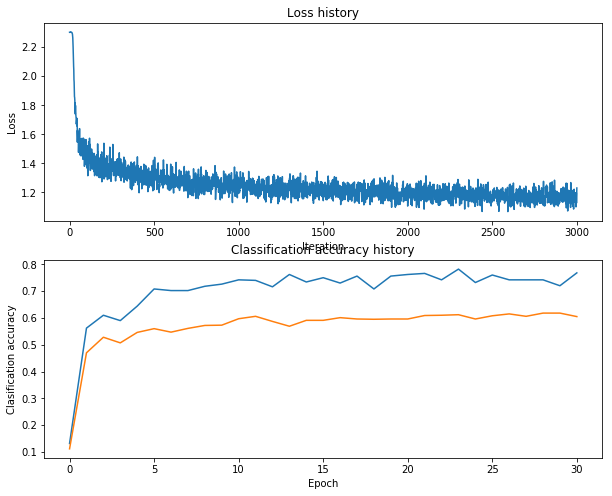

In [30]:
# Plot the loss function and train / validation accuracies
plt.subplot(2, 1, 1)
plt.plot(stats['loss_history'])
plt.title('Loss history')
plt.xlabel('Iteration')
plt.ylabel('Loss')

plt.subplot(2, 1, 2)
plt.plot(stats['train_acc_history'], label='train')
plt.plot(stats['val_acc_history'], label='val')
plt.title('Classification accuracy history')
plt.xlabel('Epoch')
plt.ylabel('Clasification accuracy')
plt.show()

# Bonus: Design your own features!

You have seen that simple image features can improve classification performance. So far we have tried HOG and color histograms, but other types of features may be able to achieve even better classification performance.

For bonus points, design and implement a new type of feature and use it for image classification on CIFAR-10. Explain how your feature works and why you expect it to be useful for image classification. Implement it in this notebook, cross-validate any hyperparameters, and compare its performance to the HOG + Color histogram baseline.

# Bonus: Do something extra!
Use the material and code we have presented in this assignment to do something interesting. Was there another question we should have asked? Did any cool ideas pop into your head as you were working on the assignment? This is your chance to show off!